In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats as stats

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from feature_engine.outliers import Winsorizer

from tensorflow import keras
from keras.callbacks import TensorBoard 

from sklearn.model_selection import train_test_split
from feature_engine import imputation as mdi

pd.options.display.max_columns = None

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

%matplotlib inline

# Jupyter Notebook'un zekasını etkinleştirir.
%config IPCompleter.greedy=True

# Tüm içerikleri göstermeyi sağlar. 
pd.set_option('display.max_colwidth', None)

In [6]:
x_train = pd.read_csv("House_train.csv")
y_train = pd.read_csv("House_test.csv")
y_test = pd.read_csv("House_sample_submission.csv")

x_test = x_train["SalePrice"]
x_train.drop("SalePrice",axis=1,inplace=True)
y_test.drop("Id",axis=1,inplace=True)

In [7]:
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# çok fazla nan olanları sil
x_train.drop(['Id','Alley','PoolQC','Fence','MiscFeature','FireplaceQu'],inplace=True,axis=1)
y_train.drop(['Id','Alley','PoolQC','Fence','MiscFeature','FireplaceQu'],inplace=True,axis=1)

In [5]:
# ****** Sadece sayısala verileri aldık *******
# taktik : describle yaparken sadece sayısal değerler alınır bunu kullanarak sütun isimlerini aldık ve bu sütunları df yaptık

dato=x_train.describe() # ortalama toplan vb bilgiler var
columnas=dato.columns.values.tolist()
x_train=pd.DataFrame(x_train[columnas],columns=columnas)

dato=y_train.describe() 
columnas=dato.columns.values.tolist()
y_train=pd.DataFrame(y_train[columnas],columns=columnas)


In [6]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1452 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [7]:
# NaN sütunlar için

vacios = [var for var in x_train.columns if x_train[var].isnull().mean() > 0]
x_train[vacios].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

In [8]:
# LotFrontAge'da %5'ten fazla eksik değere sahip olduğumuz için bir devamsızlık göstergesi ekleyeceğiz.

print(x_train["LotFrontage"])
''' Bu kodu bi araştır tam anlamadım ne olduğunu '''

indicador= mdi.AddMissingIndicator(variables=['LotFrontage'])
indicador.fit(x_train)
x_train=indicador.transform(x_train)


garaje=mdi.CategoricalImputer(imputation_method='frequent',
                              variables=['LotFrontage'],
                              ignore_format=True)
garaje.fit(x_train)
x_train=garaje.transform(x_train)

# -----

medianas=mdi.MeanMedianImputer(imputation_method='median',
                               variables=['MasVnrArea','GarageYrBlt'])
medianas.fit(x_train)
x_train=medianas.transform(x_train)
x_train['LotFrontage_na'] = x_train['LotFrontage_na'].astype(int)

0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1460, dtype: float64


MSSubClass


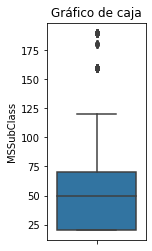

LotFrontage


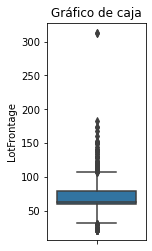

LotArea


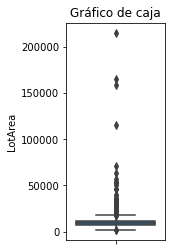

OverallQual


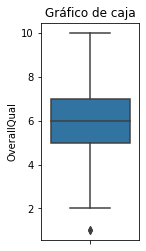

OverallCond


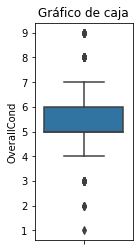

YearBuilt


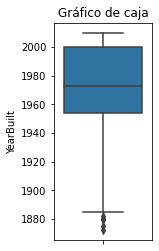

YearRemodAdd


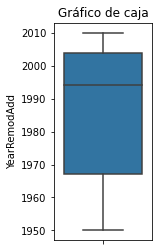

MasVnrArea


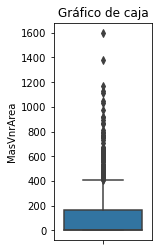

BsmtFinSF1


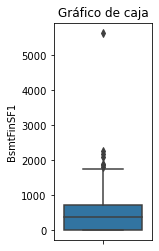

BsmtFinSF2


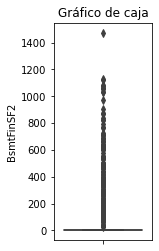

BsmtUnfSF


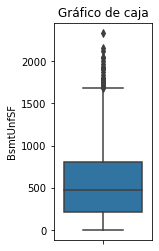

TotalBsmtSF


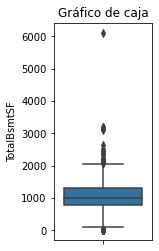

1stFlrSF


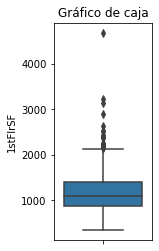

2ndFlrSF


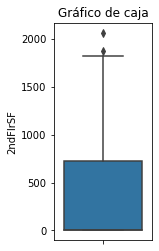

LowQualFinSF


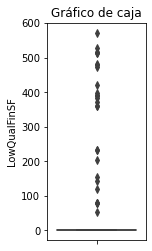

GrLivArea


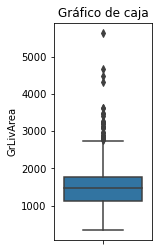

BsmtFullBath


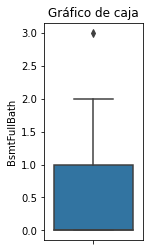

BsmtHalfBath


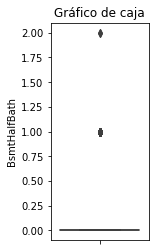

FullBath


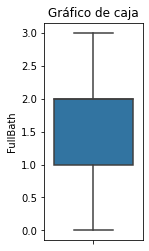

HalfBath


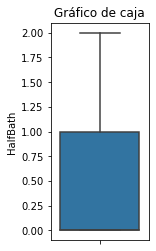

BedroomAbvGr


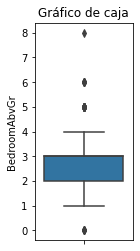

KitchenAbvGr


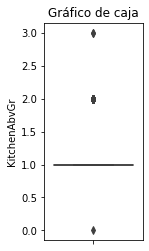

TotRmsAbvGrd


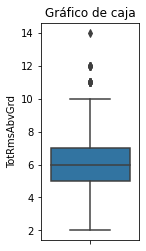

Fireplaces


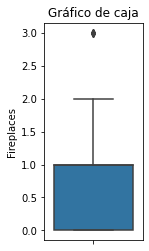

GarageYrBlt


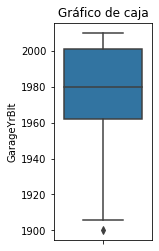

GarageCars


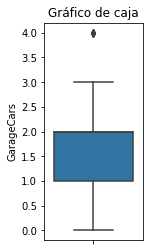

GarageArea


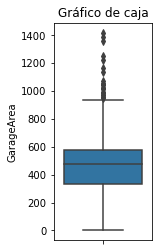

WoodDeckSF


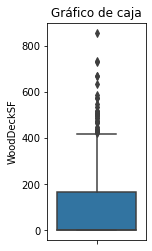

OpenPorchSF


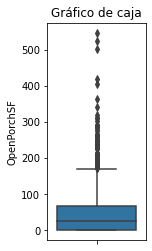

EnclosedPorch


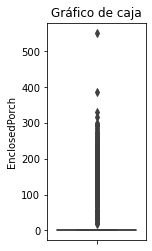

3SsnPorch


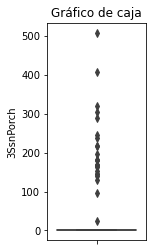

ScreenPorch


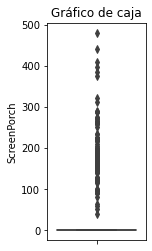

PoolArea


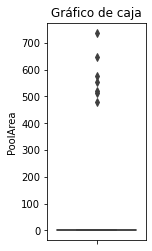

MiscVal


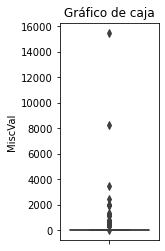

MoSold


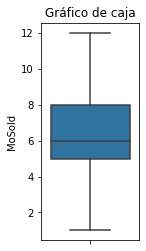

YrSold


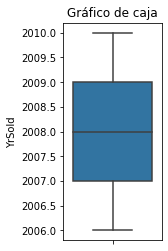

LotFrontage_na


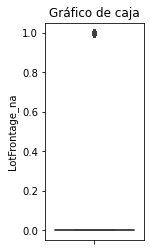

In [9]:
def diagnostic_plots(x_train, variable):
    plt.subplot(1, 3, 3)
    sns.boxplot(y=x_train[variable])

    plt.show()

columnas=x_train.columns.values.tolist()
for x in columnas:
  print(x)
  diagnostic_plots(x_train,x)

In [10]:
#  Aykırı değerler için ölçekleyici uygulaması

windsoriser = Winsorizer(capping_method='iqr', 
                          tail='both',
                          fold=3,
                          variables=['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold'])

windsoriser.fit(x_train)

x_train=windsoriser.transform(x_train)

In [11]:
x_test=x_test/x_test.max()

In [12]:
# scaler yapmış sayıları belli bir aralığa sokmak için sanırım train test diye ayırması hala tuhafıma gidiyor
# x_test i zaten yukarda scaler etmiştik neden tekrar ediyoruz

X_train, X_test, Y_train, Y_test = train_test_split(x_train,
                                                    x_test,
                                                    test_size=0.05,
                                                    random_state=0)
scaler = RobustScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# scaled yapınca numpy a dönüştü onu tekrar pandasa çevirelim

datos=pd.DataFrame(X_train_scaled,columns=['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'LotFrontage_na'])

datos_test=pd.DataFrame(X_test_scaled,columns=['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'LotFrontage_na'])

In [14]:
# verielri tensör e çevirdik (tensörün verinin (1D 2D )boyutunu arttırma gibi bi anlamı var)
# convert_to_tensor veriyi tensör e çevirir. Yani istenilen boyuta çevirir.
print(X_train)
X_train=tf.convert_to_tensor(X_train_scaled,np.float64)
Y_train=tf.convert_to_tensor(Y_train,np.float64)

X_test=tf.convert_to_tensor(X_test_scaled,np.float64)
Y_test=tf.convert_to_tensor(Y_test,np.float64)

      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
688         20.0         60.0   8089.0          8.0          6.0     2007.0   
1122        20.0         60.0   8926.0          4.0          3.0     1956.0   
866         20.0         67.0  10656.0          8.0          5.0     2006.0   
1214        85.0         69.0  10205.0          5.0          5.0     1962.0   
589         40.0         50.0   9100.0          5.0          6.0     1930.0   
...          ...          ...      ...          ...          ...        ...   
763         60.0         82.0   9430.0          8.0          5.0     1999.0   
835         20.0         60.0   9600.0          4.0          7.0     1950.0   
1216        90.0         68.0   8930.0          6.0          5.0     1978.0   
559        120.0         60.0   3196.0          7.0          5.0     2003.0   
684         60.0         58.0  16770.0          7.0          5.0     1998.0   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFin

In [15]:
'''  Sanırım pandası makine öğrenmesine veremediği için numpya çevirmiş  '''
X_train

'  Sanırım pandası makine öğrenmesine veremediği için numpya çevirmiş  '

In [17]:
layers=[Dense(units=37,  
                           input_shape=(37,),
                           kernel_initializer="he_uniform",
                           activation='relu',
                           kernel_regularizer=keras.regularizers.l1(l=0.001)),
                              
        Dense(units=95,
                           kernel_initializer="he_uniform",
                           activation='relu',
                           kernel_regularizer=keras.regularizers.l1(l=0.001)),
        Dense(units=180,
                           kernel_initializer="he_uniform",
                           activation='relu',
                           kernel_regularizer=keras.regularizers.l1(l=0.001)),
        Dense(units=360,
                           kernel_initializer="he_uniform",
                           activation='relu',
                           kernel_regularizer=keras.regularizers.l1(l=0.001)),
        
        Dense(units=1,
                           kernel_initializer="he_uniform",
                           activation=tf.keras.activations.linear)]

model=Sequential(layers,name="multilineal_regression")

model.compile(optimizer= "adam",
              loss="mae",
              metrics=[ "mse"])

model.summary()

Model: "multilineal_regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 37)                1406      
_________________________________________________________________
dense_6 (Dense)              (None, 95)                3610      
_________________________________________________________________
dense_7 (Dense)              (None, 180)               17280     
_________________________________________________________________
dense_8 (Dense)              (None, 360)               65160     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 361       
Total params: 87,817
Trainable params: 87,817
Non-trainable params: 0
_________________________________________________________________


In [20]:
# makine öğrenimi deneyi için gereken görselleştirmeyi ve araçları sağlar
tensorboard_callback= TensorBoard(log_dir="logs")

model.fit(
    X_train,
    Y_train,
    epochs=500, 
    batch_size=400, 
    validation_split=0.05, 
    callbacks=[tensorboard_callback])

results= model.evaluate(X_test, Y_test)

Epoch 1/500
4/4 [==============================] - 3s 190ms/step - loss: 9.9298 - mse: 1.2859 - val_loss: 9.6347 - val_mse: 0.7356
Epoch 2/500
4/4 [==============================] - 0s 22ms/step - loss: 9.3232 - mse: 0.3563 - val_loss: 9.3153 - val_mse: 0.4011
Epoch 3/500
4/4 [==============================] - 0s 22ms/step - loss: 9.0967 - mse: 0.2183 - val_loss: 8.9275 - val_mse: 0.1687
Epoch 4/500
4/4 [==============================] - 0s 23ms/step - loss: 8.8753 - mse: 0.1610 - val_loss: 8.6269 - val_mse: 0.0528
Epoch 5/500
4/4 [==============================] - 0s 23ms/step - loss: 8.6385 - mse: 0.0821 - val_loss: 8.4763 - val_mse: 0.0537
Epoch 6/500
4/4 [==============================] - 0s 22ms/step - loss: 8.4169 - mse: 0.0483 - val_loss: 8.3400 - val_mse: 0.0626
Epoch 7/500
4/4 [==============================] - 0s 22ms/step - loss: 8.2506 - mse: 0.0436 - val_loss: 8.1575 - val_mse: 0.0498
Epoch 8/500
4/4 [==============================] - 0s 24ms/step - loss: 8.0825 - mse: 0.0

4/4 [==============================] - 0s 22ms/step - loss: 1.4507 - mse: 0.0012 - val_loss: 1.4461 - val_mse: 9.7911e-04
Epoch 126/500
4/4 [==============================] - 0s 22ms/step - loss: 1.4349 - mse: 0.0012 - val_loss: 1.4307 - val_mse: 9.9584e-04
Epoch 127/500
4/4 [==============================] - 0s 22ms/step - loss: 1.4206 - mse: 0.0013 - val_loss: 1.4163 - val_mse: 9.7830e-04
Epoch 128/500
4/4 [==============================] - 0s 22ms/step - loss: 1.4054 - mse: 0.0012 - val_loss: 1.4013 - val_mse: 9.4865e-04
Epoch 129/500
4/4 [==============================] - 0s 22ms/step - loss: 1.3909 - mse: 0.0013 - val_loss: 1.3869 - val_mse: 9.8647e-04
Epoch 130/500
4/4 [==============================] - 0s 23ms/step - loss: 1.3767 - mse: 0.0013 - val_loss: 1.3719 - val_mse: 9.2050e-04
Epoch 131/500
4/4 [==============================] - 0s 22ms/step - loss: 1.3622 - mse: 0.0013 - val_loss: 1.3590 - val_mse: 0.0010
Epoch 132/500
4/4 [==============================] - 0s 22ms/step 

4/4 [==============================] - 0s 22ms/step - loss: 0.4259 - mse: 0.0015 - val_loss: 0.4215 - val_mse: 6.6328e-04
Epoch 246/500
4/4 [==============================] - 0s 22ms/step - loss: 0.4217 - mse: 0.0015 - val_loss: 0.4196 - val_mse: 7.8656e-04
Epoch 247/500
4/4 [==============================] - 0s 23ms/step - loss: 0.4182 - mse: 0.0015 - val_loss: 0.4150 - val_mse: 6.8894e-04
Epoch 248/500
4/4 [==============================] - 0s 22ms/step - loss: 0.4152 - mse: 0.0016 - val_loss: 0.4103 - val_mse: 7.2904e-04
Epoch 249/500
4/4 [==============================] - 0s 22ms/step - loss: 0.4105 - mse: 0.0015 - val_loss: 0.4056 - val_mse: 6.8837e-04
Epoch 250/500
4/4 [==============================] - 0s 22ms/step - loss: 0.4058 - mse: 0.0015 - val_loss: 0.4014 - val_mse: 6.5290e-04
Epoch 251/500
4/4 [==============================] - 0s 22ms/step - loss: 0.4022 - mse: 0.0016 - val_loss: 0.3989 - val_mse: 7.5255e-04
Epoch 252/500
4/4 [==============================] - 0s 23ms/s

4/4 [==============================] - 0s 22ms/step - loss: 0.1461 - mse: 0.0016 - val_loss: 0.1438 - val_mse: 6.7762e-04
Epoch 366/500
4/4 [==============================] - 0s 21ms/step - loss: 0.1451 - mse: 0.0016 - val_loss: 0.1433 - val_mse: 7.5218e-04
Epoch 367/500
4/4 [==============================] - 0s 22ms/step - loss: 0.1442 - mse: 0.0016 - val_loss: 0.1419 - val_mse: 6.7514e-04
Epoch 368/500
4/4 [==============================] - 0s 22ms/step - loss: 0.1434 - mse: 0.0016 - val_loss: 0.1408 - val_mse: 7.2503e-04
Epoch 369/500
4/4 [==============================] - 0s 22ms/step - loss: 0.1420 - mse: 0.0016 - val_loss: 0.1395 - val_mse: 7.0900e-04
Epoch 370/500
4/4 [==============================] - 0s 22ms/step - loss: 0.1409 - mse: 0.0016 - val_loss: 0.1384 - val_mse: 6.7435e-04
Epoch 371/500
4/4 [==============================] - 0s 22ms/step - loss: 0.1399 - mse: 0.0016 - val_loss: 0.1382 - val_mse: 7.7585e-04
Epoch 372/500
4/4 [==============================] - 0s 26ms/s

4/4 [==============================] - 0s 22ms/step - loss: 0.0687 - mse: 0.0015 - val_loss: 0.0683 - val_mse: 7.1890e-04
Epoch 486/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0684 - mse: 0.0015 - val_loss: 0.0680 - val_mse: 6.9973e-04
Epoch 487/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0681 - mse: 0.0015 - val_loss: 0.0676 - val_mse: 6.9247e-04
Epoch 488/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0678 - mse: 0.0015 - val_loss: 0.0672 - val_mse: 7.1058e-04
Epoch 489/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0673 - mse: 0.0015 - val_loss: 0.0669 - val_mse: 6.9325e-04
Epoch 490/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0671 - mse: 0.0015 - val_loss: 0.0667 - val_mse: 7.2575e-04
Epoch 491/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0667 - mse: 0.0015 - val_loss: 0.0664 - val_mse: 7.0174e-04
Epoch 492/500
4/4 [==============================] - 0s 21ms/s

In [21]:
print(results)

[0.06934507191181183, 0.002233927370980382]


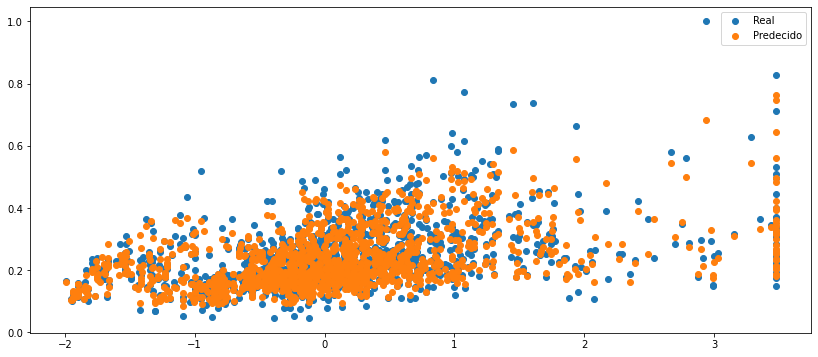

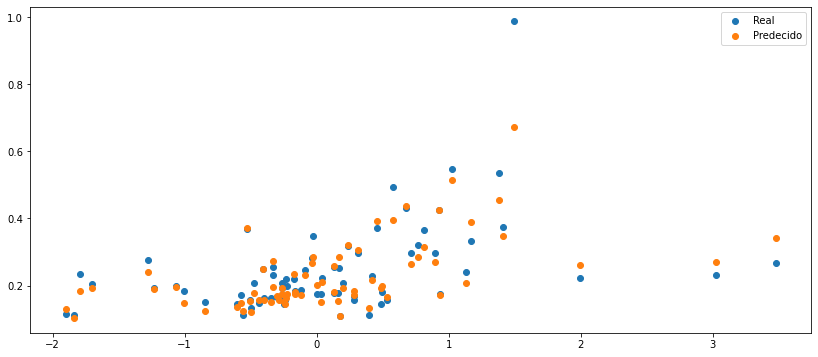

In [23]:
def print_regression_line(model,X_print,X,Y):
  plt.rcParams["figure.figsize"]=(14,6)
  plt.rcParams["lines.linewidth"]= 3
  plt.rcParams["axes.labelsize"]= 20
  plt.scatter(X_print, Y, label="Real")
  plt.scatter(X_print, model.predict(X).flatten(), label="Predecido")
  plt.legend(["Real", "Predecido"])
  plt.show()

print_regression_line(model,datos["LotArea"],X_train,Y_train)
print_regression_line(model,datos_test["LotArea"],X_test,Y_test)

In [25]:
# data tipi tensor şeklinde geliyor burayı tam anlamadım

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,random_state=1)
rf.fit(X_train,Y_train)

print("Rastgele Orman Modeli Test Doğruluğu: {}".format(rf.score(X_test,Y_test)))

tf.Tensor(
[[-6.00000000e-01 -1.57894737e-01  3.47684621e+00 ... -1.00000000e+00
  -5.00000000e-01  1.00000000e+00]
 [ 0.00000000e+00  8.42105263e-01  2.43724104e-03 ...  6.66666667e-01
  -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.57894737e-01 -6.00779917e-01 ...  3.33333333e-01
   5.00000000e-01  1.00000000e+00]
 ...
 [ 2.00000000e-01  4.21052632e-01 -4.10675116e-01 ...  3.33333333e-01
   5.00000000e-01  0.00000000e+00]
 [ 2.80000000e+00 -6.84210526e-01 -5.02071655e-01 ... -1.66666667e+00
   0.00000000e+00  0.00000000e+00]
 [-6.00000000e-01  5.78947368e-01  1.76943700e-01 ...  3.33333333e-01
   5.00000000e-01  0.00000000e+00]], shape=(73, 37), dtype=float64)
